# 1. Lending Club Risk Analysis - Introduction

With technological advances, people can now invest in other people's loans using online peer-to-peer lending platforms like, Lending Club. So far the most straightforward metric for identifying risk / reward is available to investors: higher interest rate means more risk (lower investment grade), lower interest rate means less risk (higher investment grade). Attempt to identifying other features that should be used to identify whether a loan is going to performs poorly (Default or be Charged Off) or will do just fine (Fully Paid) using Machine Leaning techniques.

Goal of the project:

Given Lending Club data on 2M+ loans can we classify them into the defaulting ones vs fully paid ones? If we are an investor seeking to allocate some of our capital into asset-based lending, can we build a model that would flag problematic loans early on?

Seconday questions include: what drives a loan to default? are there any problematic demographic clusters that are correlated with high default rates?

Background knowledge:

The term “default” lacks specificity, as many credit card companies have moved away from using it to describe overdue card payments. In the strictest terms, an account is in default if you haven’t made a payment by the due date. However, the term has come to be used to describe any debt that the card issuer no longer expects to be paid in full.

When a credit card company has decided that the outstanding debt they’re owed is unlikely to be paid at all, they will typically “charge-off” the debt. What this means to the card issuer is the entire amount of the outstanding debt, plus interest and fees, goes onto their books as an uncollectable debt.

Target:

Out target then is to predict Charged Off and Defaults together, collectively, they will represent "bad" loans.

## 1.1 Project Structure
Now that we have an idea what a "bad" loan is, let us define labels for bad loans:
- Charged Off
- Default

Let's do the same for good loans and provide some definition. For the purposes of this analysis, we choose good loans to have the following charachteristics:
- Fully Paid

<b> We will thus ignore In Grace Period and Current loans, as we do not know whether they are "good" or "bad" and they will confuse our model. </b>

In [1]:
# Standard for Data
import pandas as pd
import numpy as np
import math
import pandas.api.types as ptypes

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Machine
import os

# Aesthetics for Coding
import warnings
warnings.simplefilter(action='ignore', category = DeprecationWarning)
warnings.simplefilter(action='ignore', category = FutureWarning)

# 2. Data Processing

## 2.1 Dataset
I first started this project using [LC dataset provided by Wendy Kan](https://www.kaggle.com/wendykan/lending-club-loan-data) but realized that this dataset is missing a lot of useful information, like FICO scores. So I am now using the [dataset provided by Nathan George](https://www.kaggle.com/wordsforthewise/lending-club), which has all available features.

In [2]:
data = pd.read_csv('datasets_902_370089_accepted_2007_to_2018Q4.csv', parse_dates=['issue_d'], infer_datetime_format=True)

/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(data.issue_d.describe())
data.head()

count                 2260668
unique                    139
top       2016-03-01 00:00:00
freq                    61992
first     2007-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data_use = data[(data.issue_d >= '2017-01-01')]

In [5]:
data_use.shape

(938821, 151)

We have 151 features available and ~1M loans to use as our training / validation / test sets to build a model. For the usefulness of this project, it is vital to keep in mind which features we should use to build this model, as not all features are available to investors when they make a decision to invest.

To better understand what each features is we will use [LC Data Dictionary](https://www.kaggle.com/wendykan/lending-club-loan-data)

In [6]:
var_description = pd.read_excel('LCDataDictionary.xlsx')
var_description.dropna(inplace=True)
var_description.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000, "display.max_colwidth", 1000): 
        display(df)

In [8]:
# Lookup Feature here:
display_all(var_description[var_description.LoanStatNew.str.contains('util')])

,LoanStatNew,Description
3,all_util,Balance to credit limit on all trades
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.
28,il_util,Ratio of total current balance to high credit/credit limit on all install acct
91,revol_util,"Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."
122,sec_app_revol_util,Ratio of total current balance to high credit/credit limit for all revolving accounts


## 2.2 Data Cleaning

### 2.2.1 Percent missing

In [9]:
def percent_null(df):
    num_null = pd.Series([sum(df[col].isnull()) for col in df.columns])
    percent_null_df = pd.DataFrame({'col':df.columns, 'Missing Values':num_null, 
                                    '% of Total Values':100*num_null/len(df)}).sort_values(by = '% of Total Values', ascending=False)
    percent_null_df = percent_null_df.loc[percent_null_df['% of Total Values'] != 0].round(1)
    percent_null_df.set_index('col', inplace = True)
    percent_null_df.index.name = None
    return percent_null_df
percent_null_df = percent_null(data_use)
display_all(percent_null_df.head())

,Missing Values,% of Total Values
member_id,938821,100.0
desc,938821,100.0
orig_projected_additional_accrued_interest,936193,99.7
hardship_length,935556,99.7
payment_plan_start_date,935556,99.7


In [10]:
sum(data_use.dti.isna())/len(data_use.dti)

0.0017532628690666273

In [11]:
percent_null_df.shape

(63, 2)

Let's delete features that have more than 90% missing values

In [12]:
to_del = list(percent_null_df[percent_null_df['% of Total Values'] > 90.0].index)
to_del.extend(['url', 'emp_title', 'title']); len(to_del)

26

### 2.2.2 Setting up a Target Varaible
We will first "clean" loan_status columns for the entire dataset to abide by our abovementioned project structure. Training data will only have "Fully Paid" (1) and "Default" / "Charged Off" (0).

In [13]:
total_loan_status = data_use.loan_status.copy()
total_loan_status.groupby(total_loan_status).count()

loan_status
Charged Off            48015
Current               689032
Default                   28
Fully Paid            177596
In Grace Period         5830
Late (16-30 days)       3095
Late (31-120 days)     15225
Name: loan_status, dtype: int64

In [14]:
data_use_tgt = data_use.loc[~(data_use.loan_status == 'Current') & ~(data_use.loan_status == 'In Grace Period')
                               & ~(data_use.loan_status == 'Late (16-30 days)')
                               & ~(data_use.loan_status == 'Late (31-120 days)'),:]

In [15]:
total_target = data_use_tgt.loan_status
print(len(total_target))
total_target.groupby(by = total_target).count()

225639


loan_status
Charged Off     48015
Default            28
Fully Paid     177596
Name: loan_status, dtype: int64

In [16]:
test_df = data_use_tgt.sample(frac=0.1, random_state = 101)

# work_df is for training and validating; and deleting to_del
work_df = data_use_tgt[~data_use_tgt.index.isin(test_df.index)].drop(to_del, axis = 1)
target_raw = work_df.loan_status.copy()
work_df = work_df.drop(['loan_status'], axis = 1)

In [17]:
test_df.loan_status.value_counts()/len(test_df.loan_status)

Fully Paid     0.785721
Charged Off    0.214191
Default        0.000089
Name: loan_status, dtype: float64

In [18]:
target_raw.value_counts()/len(target_raw)

Fully Paid     0.787231
Charged Off    0.212641
Default        0.000128
Name: loan_status, dtype: float64

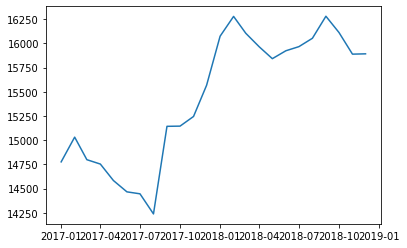

In [19]:
to_plot_loan_amnt = data_use.groupby(by='issue_d')['loan_amnt'].mean()
to_plot_loan_amnt.head()
plt.plot(to_plot_loan_amnt.index, to_plot_loan_amnt);

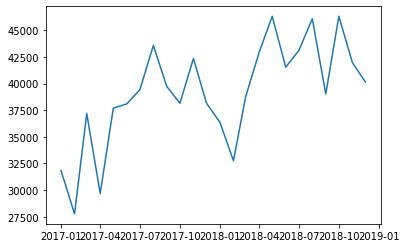

In [20]:
to_plot_loan_amnt = data_use.groupby(by='issue_d')['loan_amnt'].count()
to_plot_loan_amnt.head()
plt.plot(to_plot_loan_amnt.index, to_plot_loan_amnt);

Looks like loan amount is increasing as time goes on - this could potentially be a problem as Random Forests do not do well with time sensitive variables

### 2.2.3 Deleting leaking variables
From our previous analysis, we have identified a few leaking variables. We are going to delete these before training our model.

In [21]:
leak_feat = ['recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
             'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'debt_settlement_flag', 
             'out_prncp_inv', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'hardship_flag']
work_df = work_df.drop(leak_feat, axis = 1)

### 2.2.4 Converting work dataframe into numeric only dataframe
To ensure that we can train our random forest model, we need to convert all object data type columns to numeric ones.


In [22]:
work_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

id                           203075
term                              2
grade                             7
sub_grade                        35
emp_length                       11
home_ownership                    5
verification_status               3
pymnt_plan                        1
purpose                          13
zip_code                        887
addr_state                       50
earliest_cr_line                668
initial_list_status               2
application_type                  2
verification_status_joint         3
sec_app_earliest_cr_line        563
disbursement_method               2
dtype: int64

In [23]:
# Fixing time variables
list_time_vars = list(work_df.columns[work_df.columns.str.contains(r'_d$')])

attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
list_time_vars.extend(['earliest_cr_line', 'sec_app_earliest_cr_line'])
for var in list_time_vars:
    if pd.isnull(work_df[var]).sum(): 
        work_df[var+'_na'] = pd.isnull(work_df[var])
        work_df[var] = work_df[var].fillna(0)
    temp = pd.to_datetime(work_df[var], infer_datetime_format=True)
    work_df[var] = pd.to_datetime(work_df[var], infer_datetime_format=True).astype('int64')
    for i in attr:
        work_df[var+'_'+i] = getattr(temp.dt, i.lower())

In [24]:
# Cleaning individual columns
work_df.emp_length = work_df.emp_length.replace({'< 1 year': '0 years', '10+ years': '11 years'})
work_df.emp_length = work_df.emp_length.str.extract('([0-9]{1,2})', expand = False).fillna(value = 0).astype('int')
work_df.term = work_df.term.str.extract('([0-9]{1,2})', expand = False).fillna(value = 0).astype('int')
work_df.grade = pd.Categorical(work_df.grade, ordered = True, categories = sorted(work_df.grade.unique(), reverse = True))
work_df.sub_grade = pd.Categorical(work_df.sub_grade, ordered = True, categories = sorted(work_df.sub_grade.unique(), reverse = True))

In [25]:
# Feature engineering
work_df['annual_inc_joint' + 'na'] = pd.isnull(work_df['annual_inc_joint'])
work_df['annual_inc_joint'] = work_df['annual_inc_joint'].fillna(work_df['annual_inc'])
work_df['avg_fico'] = pd.concat([work_df.fico_range_high, work_df.fico_range_low], axis = 1).mean(axis=1)
work_df['loan_amnt_to_inc_ratio'] = work_df.loan_amnt / work_df.annual_inc_joint
work_df.drop(['fico_range_low', 'fico_range_high'], axis=1, inplace = True)

In [26]:
display_all(work_df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,disbursement_method,issue_d_Year,issue_d_Month,issue_d_Week,issue_d_Day,issue_d_Dayofweek,issue_d_Dayofyear,issue_d_Is_month_end,issue_d_Is_month_start,issue_d_Is_quarter_end,issue_d_Is_quarter_start,issue_d_Is_year_end,issue_d_Is_year_start,earliest_cr_line_Year,earliest_cr_line_Month,earliest_cr_line_Week,earliest_cr_line_Day,earliest_cr_line_Dayofweek,earliest_cr_line_Dayofyear,earliest_cr_line_Is_month_end,earliest_cr_line_Is_month_start,earliest_cr_line_Is_quarter_end,earliest_cr_line_Is_quarter_start,earliest_cr_line_Is_year_end,earliest_cr_line_Is_year_start,sec_app_earliest_cr_line_na,sec_app_earliest_cr_line_Year,sec_app_earliest_cr_line_Month,sec_app_earliest_cr_line_Week,sec_app_earliest_cr_line_Day,sec_app_earliest_cr_line_Dayofweek,sec_app_earliest_cr_line_Dayofyear,sec_app_earliest_cr_line_Is_month_end,sec_app_earliest_cr_line_Is_month_start,sec_app_earliest_cr_line_Is_quarter_end,sec_app_earliest_cr_line_Is_quarter_start,sec_app_earliest_cr_line_Is_year_end,sec_app_earliest_cr_line_Is_year_start,annual_inc_jointna,avg_fico,loan_amnt_to_inc_ratio
421101,130956066,3000.0,3000.0,3000.0,36,7.34,93.10,A,A4,9,RENT,52000.0,Source Verified,1519862400000000000,n,major_purchase,988xx,WA,0.58,0.0,883612800000000000,0.0,26.0,NaN,7.0,0.0,141.0,0.5,30.0,w,0.0,764.0,760.0,0.0,NaN,1.0,Individual,52000.0,NaN,NaN,0.0,0.0,150592.0,0.0,0.0,1.0,2.0,7.0,0.0,NaN,0.0,1.0,141.0,1.0,31000.0,1.0,2.0,2.0,3.0,25099.0,30359.0,0.5,0.0,0.0,132.0,242.0,18.0,7.0,4.0,18.0,NaN,7.0,NaN,0.0,1.0,1.0,4.0,15.0,7.0,6.0,19.0,1.0,7.0,0.0,0.0,0.0,1.0,96.7,0.0,0.0,0.0,191216.0,141.0,30500.0,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,2018,3,9,1,3,60,False,True,False,False,False,False,1998,1,1,1,3,1,False,True,False,True,False,True,True,1970,1,1,1,3,1,False,True,False,True,False,True,True,762.0,0.057692
421113,130968727,5000.0,5000.0,5000.0,36,11.98,166.03,B,B5,11,OWN,55000.0,Not Verified,1519862400000000000,n,other,300xx,GA,14.18,0.0,996624000000000000,0.0,74.0,82.0,14.0,1.0,11449.0,33.9,24.0,w,0.0,679.0,675.0,0.0,74.0,1.0,Individual,55000.0,NaN,NaN,0.0,0.0,28880.0,1.0,1.0,0.0,0.0,33.0,17431.0,63.0,2.0,2.0,4829.0,47.0,33800.0,0.0,1.0,1.0,2.0,2222.0,10551.0,52.0,0.0,0.0,77.0,199.0,3.0,3.0,0.0,3.0,NaN,12.0,NaN,1.0,3.0,3.0,4.0,7.0,6.0,13.0,18.0,3.0,14.0,0.0,0.0,0.0,2.0,95.7,33.3,1.0,0.0,61551.0,28880.0,22000.0,27751.0,NaN

In [27]:
# save state mapping
state_code_map_initial = dict( enumerate(pd.Categorical(work_df['addr_state'], ordered = True).categories ) )

state_code_map = {}
for st_pair in state_code_map_initial.items():
    state_code_map[st_pair[0]+1] = st_pair[1]

For some of the numeric features the missing values should be filled using the maximum value of the respective columns so these features are placed in the list fill_max. For example, the feature mths_since_last_record indicates the number of months since the last record (like bankruptcy, foreclosure, tax liens, etc.) so if missing, one should assume that no records were made and the number of months since the "last" record should be a maximum.

In [28]:
fill_max = ['bc_open_to_buy', 'mo_sin_old_il_acct', 'mths_since_last_delinq',
            'mths_since_last_major_derog', 'mths_since_last_record',
            'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
            'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq']

work_df[fill_max] = work_df[fill_max].fillna(work_df[fill_max].max())

In [29]:
# Converting object variables into categorical and imputing NA values
for n,c in work_df.items():
    if ptypes.is_numeric_dtype(c):
        if pd.isnull(c).sum():
            work_df[n+'_na'] = pd.isnull(c)
            work_df[n] = c.fillna(c.median())
    if ptypes.is_string_dtype(c):
        work_df[n] = pd.Categorical(c, ordered = True)
        work_df[n] = work_df[n].cat.codes + 1

In [30]:
display_all(work_df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,disbursement_method,issue_d_Year,issue_d_Month,issue_d_Week,issue_d_Day,issue_d_Dayofweek,issue_d_Dayofyear,issue_d_Is_month_end,issue_d_Is_month_start,issue_d_Is_quarter_end,issue_d_Is_quarter_start,issue_d_Is_year_end,issue_d_Is_year_start,earliest_cr_line_Year,earliest_cr_line_Month,earliest_cr_line_Week,earliest_cr_line_Day,earliest_cr_line_Dayofweek,earliest_cr_line_Dayofyear,earliest_cr_line_Is_month_end,earliest_cr_line_Is_month_start,earliest_cr_line_Is_quarter_end,earliest_cr_line_Is_quarter_start,earliest_cr_line_Is_year_end,earliest_cr_line_Is_year_start,sec_app_earliest_cr_line_na,sec_app_earliest_cr_line_Year,sec_app_earliest_cr_line_Month,sec_app_earliest_cr_line_Week,sec_app_earliest_cr_line_Day,sec_app_earliest_cr_line_Dayofweek,sec_app_earliest_cr_line_Dayofyear,sec_app_earliest_cr_line_Is_month_end,sec_app_earliest_cr_line_Is_month_start,sec_app_earliest_cr_line_Is_quarter_end,sec_app_earliest_cr_line_Is_quarter_start,sec_app_earliest_cr_line_Is_year_end,sec_app_earliest_cr_line_Is_year_start,annual_inc_jointna,avg_fico,loan_amnt_to_inc_ratio,dti_na,revol_util_na,dti_joint_na,il_util_na,all_util_na,avg_cur_bal_na,bc_util_na,num_tl_120dpd_2m_na,percent_bc_gt_75_na,revol_bal_joint_na,sec_app_fico_range_low_na,sec_app_fico_range_high_na,sec_app_inq_last_6mths_na,sec_app_mort_acc_na,sec_app_open_acc_na,sec_app_revol_util_na,sec_app_open_act_il_na,sec_app_num_rev_accts_na,sec_app_chargeoff_within_12_mths_na,sec_app_collections_12_mths_ex_med_na
421101,201373,3000.0,3000.0,3000.0,36,7.34,93.10,7,32,9,5,52000.0,2,1519862400000000000,1,6,876,47,0.58,0.0,883612800000000000,0.0,26.0,124.0,7.0,0.0,141.0,0.5,30.0,2,0.0,764.0,760.0,0.0,226.0,1.0,1,52000.0,18.6,0,0.0,0.0,150592.0,0.0,0.0,1.0,2.0,7.0,0.0,73.0,0.0,1.0,141.0,1.0,31000.0,1.0,2.0,2.0,3.0,25099.0,30359.0,0.5,0.0,0.0,132.0,242.0,18.0,7.0,4.0,18.0,202.0,7.0,202.0,0.0,1.0,1.0,4.0,15.0,7.0,6.0,19.0,1.0,7.0,0.0,0.0,0.0,1.0,96.7,0.0,0.0,0.0,191216.0,141.0,30500.0,0.0,24666.0,665.0,669.0,0,0.0,1.0,10.0,59.3,2.0,11.0,0.0,0.0,1,2018,3,9,1,3,60,False,True,False,False,False,False,1998,1,1,1,3,1,False,True,False,True,False,True,True,1970,1,1,1,3,1,False,True,False,True,False,True,True,762.0,0.057692,False,False,True,True,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True
421113,201408,5000.0,5000.0,5000.0,36,11.9

In [31]:
work_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

Text(0, 0.5, 'Data type')

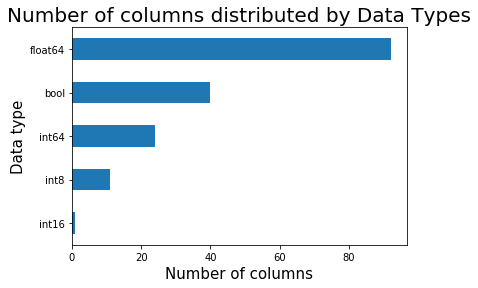

In [32]:
work_df.dtypes.value_counts().sort_values().plot(kind = 'barh');
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

### 2.2.5 Multicollinearity
Although highly correlated features (multicollinearity) aren't a problem for the machine learning models based on decision trees (as used here), these features decrease importances of each other and can make feature analysis more difficult. Therefore, we calculate feature correlations and remove the features with very high correlation coefficients before applying machine learning.

In [33]:
from itertools import combinations
from scipy.stats import pearsonr

num_feat = work_df.select_dtypes('number').columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(work_df[comb[0]], work_df[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [34]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
#high_corr_num

/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


In [35]:
np.unique(high_corr_num[:, 1])

array(['annual_inc_joint', 'earliest_cr_line_Dayofyear',
       'earliest_cr_line_Year', 'funded_amnt', 'funded_amnt_inv', 'grade',
       'installment', 'issue_d', 'issue_d_Dayofyear',
       'mo_sin_old_rev_tl_op', 'num_rev_tl_bal_gt_0', 'num_sats',
       'sec_app_earliest_cr_line', 'sec_app_earliest_cr_line_Dayofyear',
       'sec_app_earliest_cr_line_Week', 'sec_app_earliest_cr_line_Year',
       'sec_app_fico_range_high', 'sub_grade', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_il_high_credit_limit'], dtype='<U34')

In [36]:
X_tr_vl = work_df.drop(np.unique(high_corr_num[:, 1]), axis=1, errors='ignore')

The question we must answer is, do the FICO credit scores information into the future? Recall a column is considered leaking information when especially it won’t be available at the time we use our model – in this case when we use our model on future loans.

After looking through some of the feature documentation we identify that 'last_fico_range_low' and 'last_fico_range_high' are indeed leaking featurs. So we must drop them, as they wouldn't be available for the loan origination analysis.


In [37]:
leak_fico_columns = ['last_fico_range_high','last_fico_range_low']
corr_columns = ['id', 'zip_code']
X_tr_vl = pd.concat([X_tr_vl, work_df.issue_d, work_df.grade], axis = 1).drop(leak_fico_columns, axis = 1)
X_tr_vl = X_tr_vl.drop(corr_columns, axis = 1)

# 3. Modeling
## 3.1 Random Forest Model
## 3.1.1 First Random Forest Model
The goal of his first random forest is to give us some insight into what columns are most important, what is working and what needs adjustments. 

In [38]:
import math
def rmse(predicted, true_vals): return math.sqrt(((predicted-true_vals)**2).mean())

def print_score(m, X_t, X_v, y_t, y_v):
    train_pred = m.predict(X_t)
    valid_pred = m.predict(X_v)
    res = pd.DataFrame({'train_rmse':[rmse(train_pred, y_t)], 'valid_rmse':[rmse(valid_pred, y_v)],
                        'train_recall':[metrics.recall_score(y_t, train_pred)], 
                        'valid_recall':[metrics.recall_score(y_v, valid_pred)],
                        'train_precision':[metrics.precision_score(y_t, train_pred)], 
                        'valid_precision':[metrics.precision_score(y_v, valid_pred)],
                        'train_accuracy':[metrics.accuracy_score(y_t, train_pred)],
                        'valid_accuracy':[metrics.accuracy_score(y_v, valid_pred)]
                       })
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    return res

In [39]:
target_raw.value_counts()

Fully Paid     159867
Charged Off     43182
Default            26
Name: loan_status, dtype: int64

In [40]:
target = target_raw.copy()
target.loc[(target == 'Charged Off') | (target == 'Default')] = 0
target[~target.index.isin(target[target==0].index)] = 1

print(target.value_counts()/len(target))

X = X_tr_vl.copy()

1    0.787231
0    0.212769
Name: loan_status, dtype: float64


In [41]:
def train_valid_dfs(df, y_tgt, prop_tr):
    """ Creates train and validation sets using predefined work_df and target sets"""
    np.random.seed(101)
    idxs = y_tgt.groupby(y_tgt).apply(lambda x: x.sample(frac=prop_tr)).index.get_level_values(1)
    y_train = y_tgt.loc[idxs]
    
    y_valid = y_tgt[~y_tgt.index.isin(y_train.index)]
    
    train_df = df.loc[idxs]
    valid_df = df[~df.index.isin(train_df.index)]
    
    return train_df, valid_df, y_train, y_valid

X_train, X_valid, y_train, y_valid = train_valid_dfs(X, target, 0.7)

In [42]:
y_train = y_train.astype('int')

y_valid = y_valid.astype('int')

In [43]:
y_train.value_counts()

1    111907
0     30246
Name: loan_status, dtype: int64

In [44]:
y_valid.value_counts()

1    47960
0    12962
Name: loan_status, dtype: int64

In [45]:
# Random Forest Model with default parameters and data as is
m_rf = RandomForestClassifier(n_jobs = -1)
m_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [46]:
print_score(m_rf, X_train, X_valid, y_train, y_valid)

,train_rmse,valid_rmse,train_recall,valid_recall,train_precision,valid_precision,train_accuracy,valid_accuracy
0,0.0,0.454307,1.0,0.985759,1.0,0.79903,1.0,0.793605


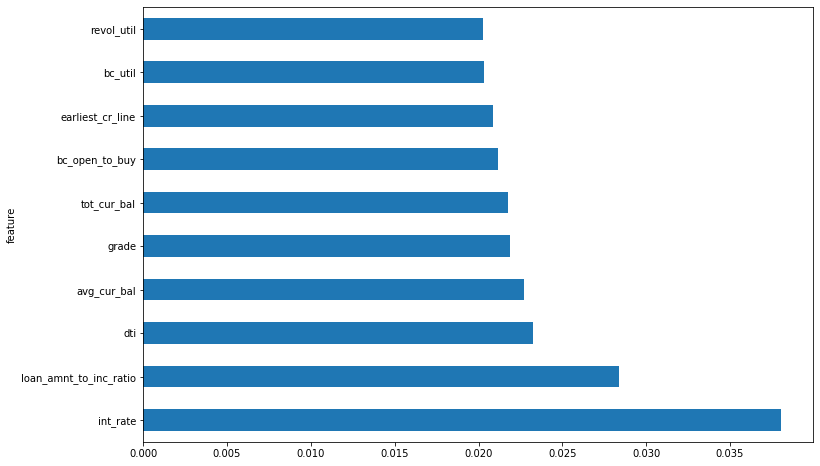

In [168]:
feat_imp = pd.DataFrame({'feature' : X_train.columns, 'imp' : m_rf.feature_importances_}).sort_values(by='imp', ascending = False)
feat_imp[:10].plot('feature', 'imp', 'barh', figsize=(12,8), legend = False);

In [169]:
feat_imp[feat_imp.feature.isin(['purpose', 'home_ownership', 'emp_length'])]

,feature,imp
3,emp_length,0.010513
8,purpose,0.008743
4,home_ownership,0.006269


In [170]:
print(metrics.classification_report(y_valid, m_rf.predict(X_valid)))
print(metrics.confusion_matrix(y_valid, m_rf.predict(X_valid)))

              precision    recall  f1-score   support

           0       0.61      0.08      0.15     12962
           1       0.80      0.99      0.88     47960

    accuracy                           0.79     60922
   macro avg       0.70      0.53      0.51     60922
weighted avg       0.76      0.79      0.73     60922

[[ 1071 11891]
 [  683 47277]]


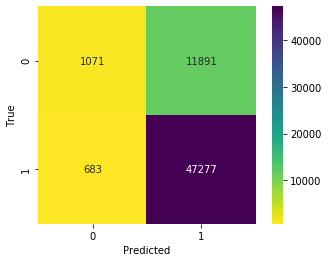

In [171]:
cm = metrics.confusion_matrix(y_valid, m_rf.predict(X_valid))
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

The random forest model we trained is performing OK. Unfortunately is doing a poor job at identifying default loans and is biased towards class 1, the most prominent class. Evidence to support this claim is a low recall rate on 0 class and low precision for class 1. Solutions:
- Upsampling the 0 class
- Reduce the number of features available to train by only keeping important features as we may be facing overfitting
- Increase max_samples_leaf

Right now the goal is to increase class 1 precision as just like in the business setting we care mostly about not making a bad investment that has high probability of default. We are OK reducing predictive power for class 0, since we are focusing on class 1.

Lastly, it is extremely surprising that 'purpose', 'emp_length', and 'home_ownership features did not make it even into the top 20 important features. We are going to keep them as they are crucial in determining one's ability to pay their debts!

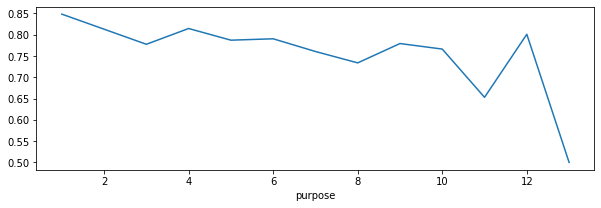

In [147]:
pd.concat([X_train, y_train], axis = 1).groupby(by = 'purpose')['loan_status'].mean().plot(figsize=(10,3))

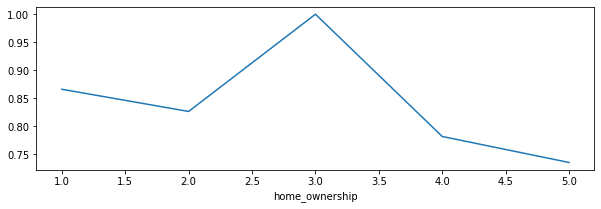

In [148]:
pd.concat([X_train, y_train], axis = 1).groupby(by = 'home_ownership')['loan_status'].mean().plot(figsize=(10,3))

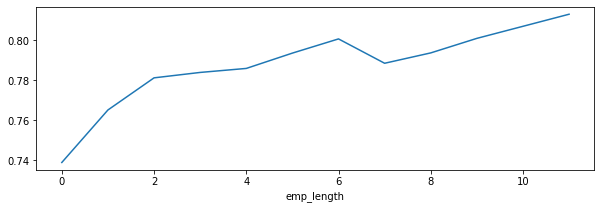

In [149]:
pd.concat([X_train, y_train], axis = 1).groupby(by = 'emp_length')['loan_status'].mean().plot(figsize=(10,3))

In [53]:
data_use.home_ownership.value_counts()

MORTGAGE    456343
RENT        369049
OWN         112542
ANY            883
NONE             4
Name: home_ownership, dtype: int64

### 3.1.2 Second Random Forest Model
Now we know what is going wrong and we have a lose plan how to fix it, or at least know what is and what is not working. 
- We are going to start by deleting unimportant variables to train our model only on features that make the most difference in the loan classification. 
- Then we are going to upsample the defaul loans to ensure that enough trees have seen examples of defaults.
- Lastly, we are going to increase max_samples_leaf and decrease max_features to start avoiding potential overfitting, since our training set is growing in dimensions

In [174]:
to_keep = feat_imp[feat_imp.imp > 0.015].feature
print(len(to_keep)); print(len(feat_imp.feature))
to_keep = to_keep.append(feat_imp[feat_imp.feature.isin(['purpose', 'home_ownership', 'emp_length'])].feature)
print(len(to_keep)); print(len(feat_imp.feature))

26
145
29
145


In [175]:
# Random Forest Model 2.0 with upsampled values and modified hyperparameters
dup_idxs = y_train[y_train == 0].index
dup_tr_df = X_train.loc[dup_idxs]
X_train_dup = pd.concat([X_train, dup_tr_df, dup_tr_df], axis = 0) #
y_train_dup = pd.concat([y_train, y_train[dup_idxs], y_train[dup_idxs]], axis = 0) # 

m_rf2 = RandomForestClassifier(n_jobs = -1, min_samples_leaf = 5, max_features = 0.5)
m_rf2.fit(X_train_dup[to_keep], y_train_dup)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [176]:
print_score(m_rf2, X_train_dup[to_keep], X_valid[to_keep], y_train_dup, y_valid)

,train_rmse,valid_rmse,train_recall,valid_recall,train_precision,valid_precision,train_accuracy,valid_accuracy
0,0.034271,0.479616,0.997954,0.887239,0.999919,0.831776,0.998826,0.769968


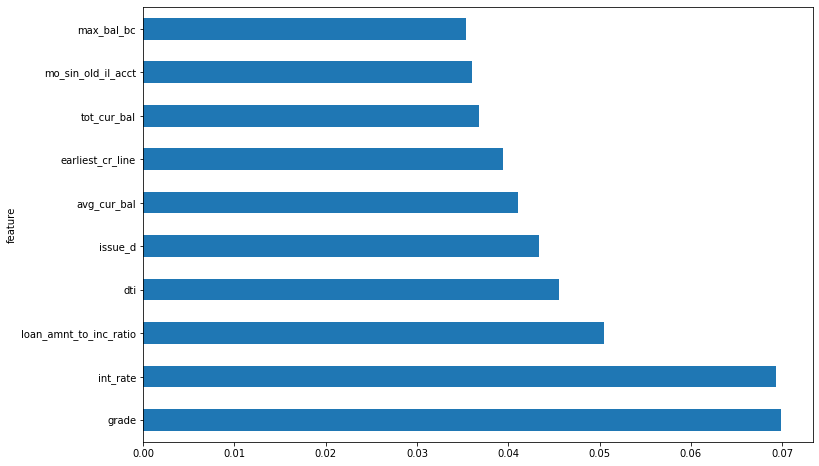

In [177]:
feat_imp = pd.DataFrame({'feature' : X_train_dup[to_keep].columns, 'imp' : m_rf2.feature_importances_}).sort_values(by='imp', ascending = False)
feat_imp[:10].plot('feature', 'imp', 'barh', figsize=(12,8), legend = False);

In [187]:
feat_imp[feat_imp.feature.isin(['purpose', 'home_ownership', 'emp_length'])]

,feature,imp
26,emp_length,0.019425
27,purpose,0.011348
28,home_ownership,0.009922


In [178]:
valid_preds = m_rf2.predict(X_valid[to_keep])
print(metrics.classification_report(y_valid, valid_preds))
print(metrics.confusion_matrix(y_valid, valid_preds))

              precision    recall  f1-score   support

           0       0.45      0.34      0.38     12962
           1       0.83      0.89      0.86     47960

    accuracy                           0.77     60922
   macro avg       0.64      0.61      0.62     60922
weighted avg       0.75      0.77      0.76     60922

[[ 4356  8606]
 [ 5408 42552]]


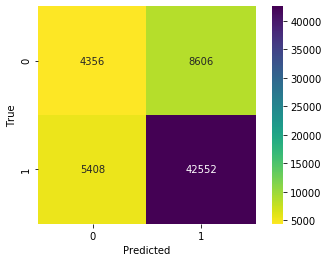

In [179]:
cm = metrics.confusion_matrix(y_valid, valid_preds)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

We are moving in the right direction. We have increased precision for class 1 and recall for class 0. Now, it seems like the model is still more comfortable predicting class 1 than 0, so let's feed another duplicate of class 0 set and force the model to train trees on a different subset of features, as there is information that is not being collected to correctly distinguish bad loans from the good ones.

Curiously, issue_d is one of the more important features. issue_d is a time variable indicating when a particular loan was issued.

In [180]:
date_viz_df = pd.concat([work_df.copy(), target.copy().astype('int')], axis = 1)
date_viz_df['issue_date'] = pd.to_datetime(date_viz_df.issue_d, unit = 'ns').dt.to_period("M")

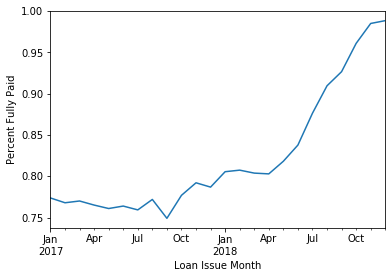

In [181]:
date_viz_df.groupby(by = 'issue_date')['loan_status'].mean().plot();
plt.xlabel('Loan Issue Month');
plt.ylabel('Percent Fully Paid');

In [182]:
date_viz_v_df = pd.concat([X_valid.copy(), y_valid.copy().astype('int')], axis = 1)
date_viz_v_df['issue_date'] = pd.to_datetime(date_viz_v_df.issue_d, unit = 'ns').dt.to_period("M")

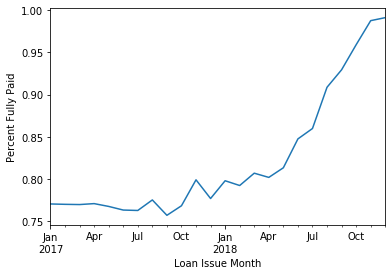

In [183]:
date_viz_v_df.groupby(by = 'issue_date')['loan_status'].mean().plot();
plt.xlabel('Loan Issue Month');
plt.ylabel('Percent Fully Paid');

Now it makes sense why issue_d is such an important variable. For some reason, after Apr-2018 number of loans that defaulted decreased. This is problematic because that means the model wouldn't generalize well to period after Oct-2018, as the model will falsely predict 1, as fully paid. Perhaps, this is why in our model tends to overpredict class 1. We still want issue_d in our forest if it is important, but let's see if deleting issue_d will make others stand out more.

### 3.1.3 Third and Final Random Forest Model
At this point we are not going to add any more class 0 data. We are going to concern ourselves only with hyperparameter tuning.

In [199]:
to_keep = feat_imp[feat_imp.imp > 0.01].feature
to_keep = to_keep.append(feat_imp[feat_imp.feature.isin(['purpose', 'home_ownership', 'emp_length'])].feature)
print(len(to_keep)); print(len(feat_imp.feature))
to_keep = to_keep.drop(to_keep[to_keep.str.contains(r'issue_d$')].index, axis = 0).drop_duplicates(keep='first')
print(len(to_keep))

31
29
28


In [200]:
# New training and validation sets to include one hot encoding of home_ownership and purpose variables

dup_idxs = y_train[y_train == 0].index
dup_tr_df = X_train.loc[dup_idxs]
X_train_dup = pd.concat([X_train, dup_tr_df, dup_tr_df], axis = 0)[to_keep] #
y_train_dup = pd.concat([y_train, y_train[dup_idxs], y_train[dup_idxs]], axis = 0) # 

X_valid_new = X_valid[to_keep]

purpose_dummies = pd.get_dummies(X_train_dup.purpose, prefix='purpose')
home_own_dummies = pd.get_dummies(X_train_dup.home_ownership, prefix='home')

X_train_dup = pd.concat([X_train_dup.drop(['purpose', 'home_ownership'], axis = 1), purpose_dummies, home_own_dummies], axis = 1)

purpose_dummies_val = pd.get_dummies(X_valid_new.purpose, prefix='purpose')
home_own_dummies_val = pd.get_dummies(X_valid_new.home_ownership, prefix='home')

for dum in purpose_dummies.columns:
    if not(dum in purpose_dummies_val.columns):
        purpose_dummies_val[dum] = 0

for dum in home_own_dummies.columns:
    if not(dum in home_own_dummies_val.columns):
        home_own_dummies_val[dum] = 0
    
X_valid_new = pd.concat([X_valid_new.drop(['purpose', 'home_ownership'], axis = 1), purpose_dummies_val, home_own_dummies_val], axis = 1)
len(X_valid_new.columns)

44

In [ ]:
# min_samples_leaf hyperparameter tuning

leaf_num = []
v_precision_scores = []
v_accuracy_scores = []
v_recall_scores = []

t_precision_scores = []
t_accuracy_scores = []
t_recall_scores = []
    
for i in range(1, 26, 3):
    print('working on {}'.format(i))
    m = RandomForestClassifier(n_jobs = -1, min_samples_leaf = i)
    m.fit(X_train_dup, y_train_dup)
    
    valid_pred = m.predict(X_valid_new)
    train_pred = m.predict(X_train_dup)
    
    leaf_num.append(i)
    v_precision_scores.append(metrics.precision_score(y_valid, valid_pred))
    v_accuracy_scores.append(metrics.accuracy_score(y_valid, valid_pred))
    v_recall_scores.append(metrics.recall_score(y_valid, valid_pred))
    
    t_precision_scores.append(metrics.precision_score(y_train_dup, train_pred))
    t_accuracy_scores.append(metrics.accuracy_score(y_train_dup, train_pred))
    t_recall_scores.append(metrics.recall_score(y_train_dup, train_pred))

In [ ]:
leaf_num = [*range(1, 26, 3)]

plt.plot(leaf_num, v_precision_scores, c= 'r', label = 'v_precision')
plt.plot(leaf_num, v_accuracy_scores, c = 'b', label = 'v_accuracy')
plt.plot(leaf_num, v_recall_scores, c = 'black', label = 'v_recall')

plt.plot(leaf_num, t_precision_scores, c= 'r', label = 't_precision', alpha = 0.2)
plt.plot(leaf_num, t_accuracy_scores, c = 'b', label = 't_accuracy', alpha = 0.2)
plt.plot(leaf_num, t_recall_scores, c = 'black', label = 't_recall', alpha = 0.2)
plt.hlines(0.84, xmin = 0, xmax = 25)
plt.hlines(0.75, xmin = 0, xmax = 25)
plt.legend(loc='upper right');

Optimal value of min_samples_lef is 12, which gives us a precision score of just above 84% on a validation set

Now, let's perform similar process with max_features

In [ ]:
# max_feature hyperparameter tuning

leaf_num = []
vv_precision_scores = []
vv_accuracy_scores = []
vv_recall_scores = []

tt_precision_scores = []
tt_accuracy_scores = []
tt_recall_scores = []
    
for i in range(1, 11):
    print('working on {}'.format(i))
    m = RandomForestClassifier(n_jobs = -1, min_samples_leaf = 12, max_features = i/10)
    m.fit(X_train_dup, y_train_dup)
    
    valid_pred = m.predict(X_valid_new)
    train_pred = m.predict(X_train_dup)
    
    leaf_num.append(i)
    vv_precision_scores.append(metrics.precision_score(y_valid, valid_pred))
    vv_accuracy_scores.append(metrics.accuracy_score(y_valid, valid_pred))
    vv_recall_scores.append(metrics.recall_score(y_valid, valid_pred))
    
    tt_precision_scores.append(metrics.precision_score(y_train_dup, train_pred))
    tt_accuracy_scores.append(metrics.accuracy_score(y_train_dup, train_pred))
    tt_recall_scores.append(metrics.recall_score(y_train_dup, train_pred))

In [ ]:
x_scaled = np.array([*range(1, 11)])/10

plt.plot(x_scaled, vv_precision_scores, c= 'r', label = 'v_precision')
plt.plot(x_scaled, vv_accuracy_scores, c = 'b', label = 'v_accuracy')
plt.plot(x_scaled, vv_recall_scores, c = 'black', label = 'v_recall')

plt.plot(x_scaled, tt_precision_scores, c= 'r', label = 't_precision', alpha = 0.2)
plt.plot(x_scaled, tt_accuracy_scores, c = 'b', label = 't_accuracy', alpha = 0.2)
plt.plot(x_scaled, tt_recall_scores, c = 'black', label = 't_recall', alpha = 0.2)
plt.hlines(0.85, xmin = 0, xmax = 1)
plt.legend(loc='upper right');

Looks like we get the best overall max_features hyperparameter is in the range between 0.2 and 0.6

Based on all the previous work we have done with hyperparameter tuning we are going to train our last model with these parameters and set n_estimators paramter to 300 to make it most robust

In [ ]:
# Random Forest Model 3.0 with upsampled values and modified hyperparameters
m_rf3 = RandomForestClassifier(n_jobs = -1, min_samples_leaf = 12, max_features = 0.3, n_estimators = 300)
m_rf3.fit(X_train_dup, y_train_dup)

In [ ]:
print_score(m_rf3, X_train_dup, X_valid_new, y_train_dup, y_valid)

In [ ]:
feat_imp = pd.DataFrame({'feature' : X_train_dup.columns, 'imp' : m_rf3.feature_importances_}).sort_values(by='imp', ascending = False)
feat_imp.plot('feature', 'imp', 'barh', figsize=(12,8), legend = False);

In [ ]:
feat_imp[feat_imp.feature.isin(['purpose', 'home_ownership'])]

In [ ]:
valid_preds = m_rf3.predict(X_valid_new)
print(metrics.classification_report(y_valid, valid_preds))
print(metrics.confusion_matrix(y_valid, valid_preds))

In [ ]:
cm = metrics.confusion_matrix(y_valid, valid_preds)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

As expected, excluding issue_d variable increased our validation precision, as now the model became more generalizable.

## 3.2 Gradient Boosting Forest
Let us now use gradient boosting classifier to inspect if a different algorithm performs better at classifying loans.

### 3.2.1 First gradient boosted forest

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [201]:
X_train_xgb = X_train.drop('issue_d', axis = 1)
X_valid_xgb = X_valid.drop('issue_d', axis = 1)

In [ ]:
xgb_m = XGBClassifier(random_state=0)
xgb_m.fit(X_train_xgb, y_train)

In [ ]:
print_score(xgb_m, X_train_xgb, X_valid_xgb, y_train, y_valid)

In [ ]:
xgb.plot_importance(xgb_m)

In [ ]:
print(metrics.classification_report(y_valid, xgb_m.predict(X_valid_xgb)))
print(metrics.confusion_matrix(y_valid, xgb_m.predict(X_valid_xgb)))

In [ ]:
cm = metrics.confusion_matrix(y_valid, xgb_m.predict(X_valid_xgb))
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

Our latest model is looking pretty good. Although we have sacrificed some of the overall accuracy of the model, we are more confident in our selected loans being paid off. We now have 83% precision when claiming that a particular loan will be paid off. 15% misclassification rate for this model can be seen as high, but this model should not be a sole determiner whether one founds a loan. It should be used as one of many tools helping you along the way. It can even help by narrowing down a universe of loan from a few thousands to a handful, where we know 15% might default and that's where the human expertise can come in to further polish the investment process.

### 3.2.2 Second Gradient Boosted Forest Model
Surprisingly, gradient boosted forest has a rather different behavior from random forest. It does similarly on both trianing and validation datsets! This may suggest that we do not need to delete variables, as overfitting is not a problem yet. 
- We are going to upsample the default loans to ensure that enough trees have seen examples of defaults.
- Modify the learning rate parameter to decrease bias.

In [202]:
# New training and validation sets to include one hot encoding of home_ownership and purpose variables

dup_idxs = y_train[y_train == 0].index
dup_tr_df = X_train.loc[dup_idxs]
X_train_dup = pd.concat([X_train, dup_tr_df, dup_tr_df], axis = 0)[to_keep] #
y_train_dup = pd.concat([y_train, y_train[dup_idxs], y_train[dup_idxs]], axis = 0) # 

X_valid_new = X_valid[to_keep]

purpose_dummies = pd.get_dummies(X_train_dup.purpose, prefix='purpose')
home_own_dummies = pd.get_dummies(X_train_dup.home_ownership, prefix='home')

X_train_dup = pd.concat([X_train_dup.drop(['purpose', 'home_ownership'], axis = 1), purpose_dummies, home_own_dummies], axis = 1)

purpose_dummies_val = pd.get_dummies(X_valid_new.purpose, prefix='purpose')
home_own_dummies_val = pd.get_dummies(X_valid_new.home_ownership, prefix='home')

for dum in purpose_dummies.columns:
    if not(dum in purpose_dummies_val.columns):
        purpose_dummies_val[dum] = 0

for dum in home_own_dummies.columns:
    if not(dum in home_own_dummies_val.columns):
        home_own_dummies_val[dum] = 0
    
X_valid_new = pd.concat([X_valid_new.drop(['purpose', 'home_ownership'], axis = 1), purpose_dummies_val, home_own_dummies_val], axis = 1)
len(X_valid_new.columns)
len(X_train_dup.columns)

44

In [203]:
# Gradient boosted model 2.0 with upsampled values and modified hyperparameters
xgb2 = XGBClassifier(learning_rate = 0.7, random_state=0)
xgb2.fit(X_train_dup, y_train_dup)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.7, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [204]:
print_score(xgb2, X_train_dup, X_valid_new, y_train_dup, y_valid)

,train_rmse,valid_rmse,train_recall,valid_recall,train_precision,valid_precision,train_accuracy,valid_accuracy
0,0.558144,0.553037,0.734065,0.722686,0.711131,0.866652,0.688475,0.69415


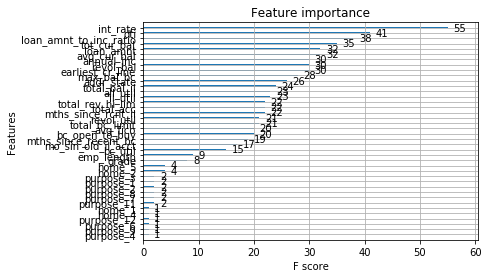

In [205]:
xgb.plot_importance(xgb2)

In [206]:
valid_preds = xgb2.predict(X_valid_new)
print(metrics.classification_report(y_valid, valid_preds))
print(metrics.confusion_matrix(y_valid, valid_preds))

              precision    recall  f1-score   support

           0       0.36      0.59      0.45     12962
           1       0.87      0.72      0.79     47960

    accuracy                           0.69     60922
   macro avg       0.62      0.66      0.62     60922
weighted avg       0.76      0.69      0.72     60922

[[ 7629  5333]
 [13300 34660]]


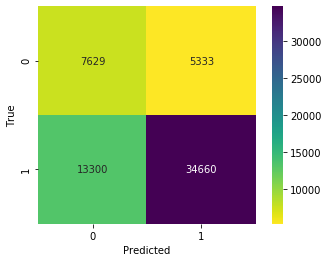

In [207]:
cm = metrics.confusion_matrix(y_valid, valid_preds)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

## Model conclusion
Random forest and gradient boosting (XGBoost) are performing quite differently. Gradient XGBoost is doing better on validation set but is not doing so well on the training one. Our final random forest model performed well on the training set but didn't get as high on the validation precision. Since we are prioritizing validaiton precision, we are going with XGBoost model - xgb2 model.

# 4. Interpretation and visualization

## 4.1 Tree interpretation

It is important to understand WHY the model is making a certain prediction - treeinterpreter does exactly that. The RF model creates multiple trees by creating best splits in data. Each group has an average class associated with the split. What treeinterpreter does is it traces the values of the particular row with the RF splits and records the marginal change in dependent class, dependent variable. So that we can see how each variable contributed to the final prediction.

Let us first visualize a simple tree to have a clear image of what is going on inside XGBoost.

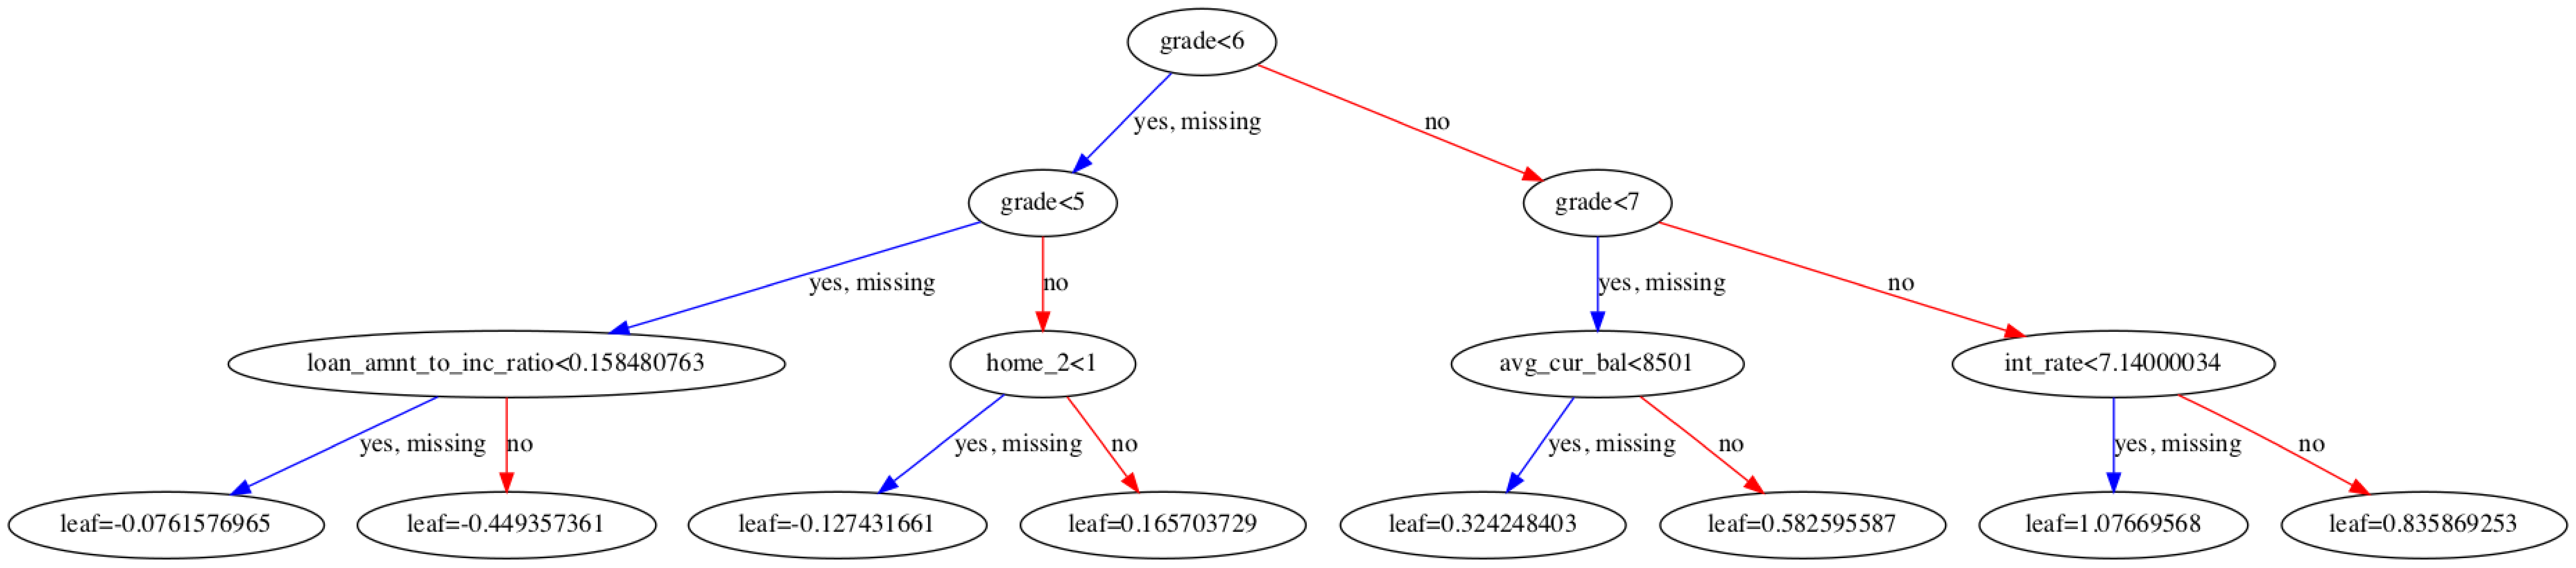

In [209]:
%matplotlib inline
from xgboost import plot_tree
import graphviz
plot_tree(xgb2)
fig = plt.gcf()
fig.set_size_inches(200, 100)

Above is an example of interpreting how a XGBoost is making a prediction and how each feature is contributing to its decision.

## 4.2 Partial dependence

Let us use the idea of partial dependence to visualize the effect of where the borrower is from (state) on their ability to complete loan obligations. We will look at the relationship between loan_status and state, all things being equal. First, let's look at the average loan_status per state as is.

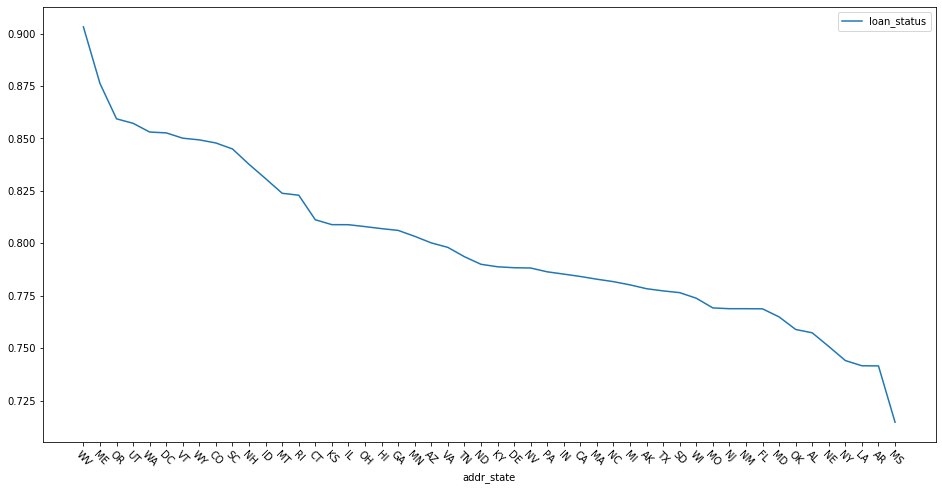

In [210]:
# Start with regular state vs avg loan_status per state vizualization
state_viz_df = pd.concat([work_df.copy(), target.copy().astype('int')], axis = 1)
state_group_df = state_viz_df.groupby('addr_state')['loan_status'].mean().reset_index()
state_group_df.set_index(state_group_df.addr_state.map(state_code_map), inplace=True)
state_group_df.drop('addr_state', axis = 1, inplace = True)
state_group_df.sort_values('loan_status', ascending = False, inplace = True)
state_group_df.plot(figsize = (16, 8))
plt.xticks( np.arange(len(state_group_df.index.tolist())), state_group_df.index.tolist(), rotation= -45 );

In [211]:
from pdpbox import pdp

In [212]:
def plot_pdp(feat, model, data, clusters=None):
    p = pdp.pdp_isolate(model, data, feature = feat, model_features=data.columns.tolist())
    return pdp.pdp_plot(p, feat, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [213]:
x = work_df.sample(frac = 500/len(work_df), replace = False)[to_keep]

purpose_dummies_x = pd.get_dummies(x.purpose, prefix='purpose')
home_own_dummies_x = pd.get_dummies(x.home_ownership, prefix='home')

for dum in purpose_dummies.columns:
    if not(dum in purpose_dummies_x.columns):
        purpose_dummies_x[dum] = 0

for dum in home_own_dummies.columns:
    if not(dum in home_own_dummies_x.columns):
        home_own_dummies_x[dum] = 0

x = pd.concat([x.drop(['purpose', 'home_ownership'], axis = 1), purpose_dummies_x, home_own_dummies_x], axis = 1)[X_train_dup.columns]

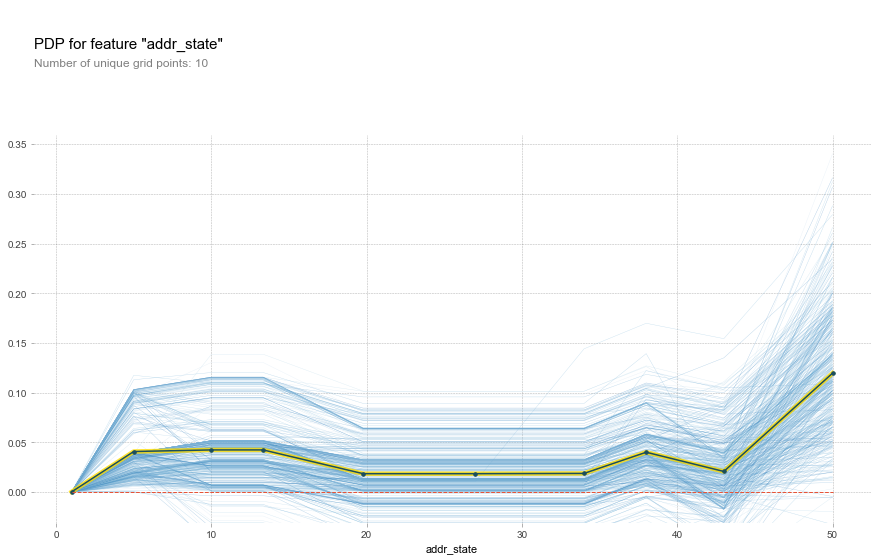

In [214]:
plot_pdp(feat = 'addr_state', model = xgb2, data = x)
plt.show()

Our partial dependence analysis shows that there aren't that drastic of a difference between states for the loan_status rediction. However, everything else being equal, if a borrower is from the state of Wyoming (WY), that loan has the highest chance to get Fully Paid. This result is different from our initial simple data visualization above.

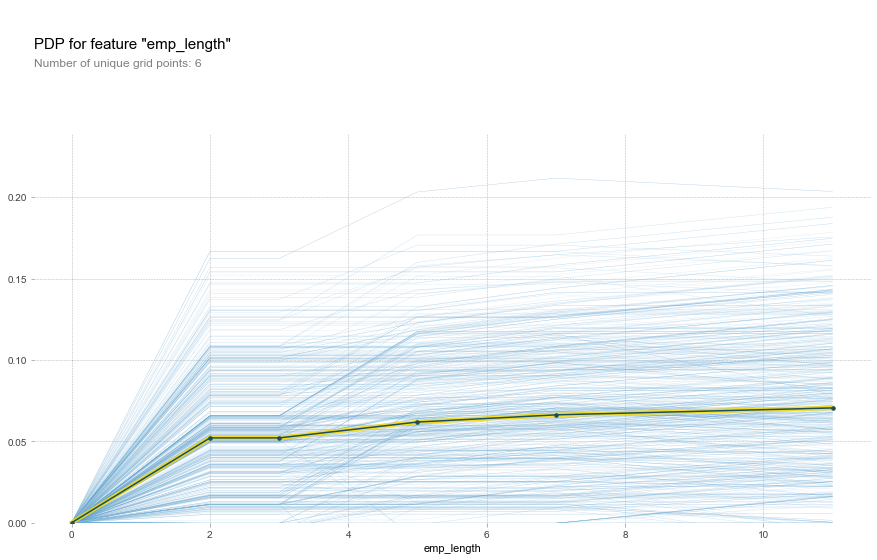

In [215]:
plot_pdp(feat = 'emp_length', model = xgb2, data = x)
plt.show()

Interestingly, based on the graph above we can conclude that there is a big difference in the contributions to the loan being Fully Paid until employment length reaches 2 years. After 5 years of employment the contribution to loan being Fully Paid stabilizes around 0.05.

## 4.3 Principal component analysis
Let us see if we can visualize the difference in loan_status using 2 principal components. We are making a controversial decision to use training data for the first random forest model with columns used to train our rf_4 model.

Before applying PCA we need to implement feature scaling, otherwise features with largest magnitude variance will be unfairly overrepresented.

## 4.3.1 Scaling and PCA components

In [231]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

rf4_X_train = X_train_dup.copy()
X_rf4_scaled = scale(rf4_X_train)

In [232]:
X_rf4_scaled[:5, :5]

array([[ 0.70383852, -0.45039354,  0.24299431,  0.78895909,  1.0825593 ],
       [ 0.70383852, -0.70671581,  0.19932009,  0.57112108, -0.50078946],
       [-0.81930408,  0.59553894, -0.74270939, -0.49234009, -0.51506297],
       [-0.05773278, -0.17514815,  0.45100968, -0.69302551,  0.91877075],
       [ 0.70383852, -1.09377964, -1.32853749, -0.46146541, -0.71905525]])

In [233]:
pca = PCA(n_components=2)
X2d = pca.fit_transform(X_rf4_scaled)
X2d = pd.DataFrame(X2d,columns=['pc1','pc2'])

In [234]:
loan_indicator = y_train.copy().reset_index(drop=  True)

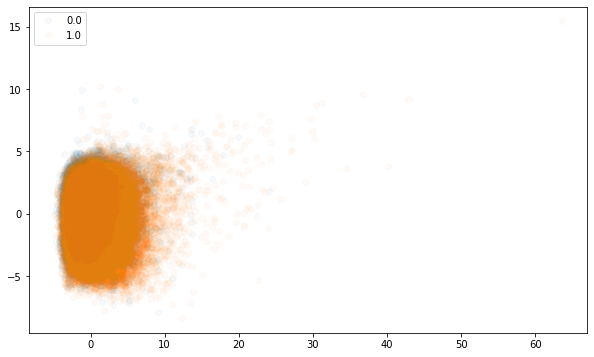

In [235]:
groups = pd.concat([X2d.copy(), loan_indicator], axis = 1).groupby('loan_status')

# Plot
fig, ax = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.pc1, group.pc2, marker='o', linestyle='', label=name, alpha = 0.03)
ax.legend()

plt.show()

#plt.scatter(X2d.pc1,X2d.pc2,alpha=0.3);

## 4.3.2 Kmeans cluster

From the picture above we can see why our models are struggling to disinguish between class 0 and class 1 (bad vs good loans). None the less there are some outliers, which could be the loans that are, in fact, bad. We know that there are 2 groups we are looking to cluster on.

In [236]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters,n_jobs=-1)
kmeans.fit(rf4_X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [237]:
X2d['label'] = kmeans.labels_
print(X2d.label.value_counts())

0    148158
1     54487
Name: label, dtype: int64


In [238]:
print(y_train.value_counts())

1    111907
0     30246
Name: loan_status, dtype: int64


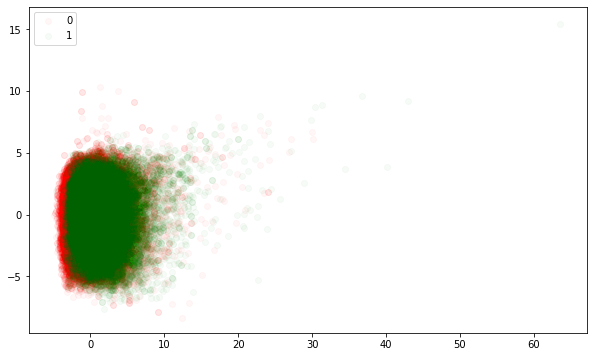

In [239]:
import itertools

colors = itertools.cycle( ['r','g'] )

plt.rc('figure',figsize=(10,6))
for label in  range(n_clusters) :
    temp = X2d.loc[X2d.label == label,:]
    plt.scatter(temp.pc1,temp.pc2,c=next(colors),label=label,alpha=0.03)

plt.legend(loc='best')

In [240]:
data_use.purpose.value_counts()/len(data_use)

debt_consolidation    0.537616
credit_card           0.233450
other                 0.072511
home_improvement      0.071836
major_purchase        0.024245
medical               0.014387
car                   0.011010
small_business        0.010141
house                 0.008976
vacation              0.008018
moving                0.007199
renewable_energy      0.000603
wedding               0.000006
educational           0.000001
Name: purpose, dtype: float64

In [241]:
X_train.purpose.value_counts()

3     77977
2     27550
4     11581
9     11381
6      3805
7      2369
1      1769
11     1507
5      1448
12     1413
8      1244
10      107
13        2
Name: purpose, dtype: int64

In [242]:
data_use.home_ownership.value_counts()/len(data_use)

MORTGAGE    0.486081
RENT        0.393098
OWN         0.119876
ANY         0.000941
NONE        0.000004
Name: home_ownership, dtype: float64

# 5. Conclusion and business impact

While analyzing this dataset, we always kept in mind the potential business objectives. Thus when it was time to build a model we focused on high precision - meaning if we do invest into one of these loans that our model is going to label as Fully Paid, we want to be as sure as possible that it actually will. Therefore we forwent some of the overall accuracy and chose the model with the highest precision for class 1.

There are numerous ways we can utilize our model to convert its insights to profit. To set the stage, we need to outline how a typical investment process evolves. Assuming our fictional investment firm is a fixed income player which has capital raised and needs to continuously reinvest to maintain a certain level return on invested capital. Each loan represents an investing opportunity, and each opportunity has to be looked at and screened by an analyst. According to Glassdoor, an average salary of an investment analyst is \\$76,000 a year, and approximately 25\% of their time is spent on screening new opportunities. Investment screening is the practice of excluding investments from portfolios based on financial criteria, aiming at avoiding poor performers. This is equivalent to \\$11,000 a year per analyst money spent on screening new opportunities.

Our first monetary gain is more efficient use of financial analyst time. Thus instead of using \\$1000 per month per analyst to look through ~20,000 applications and manually decide whether it makes the cut for each, our model does the screening for them. Our model eliminates an expensive and menial task, leaving more time for analysts to focus on due diligence for each of the pre-screened loans to obtain the level of detail a model overlooked, or wasn't trained to pick up.

Second, our analysis can be utilized by a marketing team to target demographics (states, employment length) with higest levels of Fully Paid loans. 
Firstly, there aren't that drastic differences between states for the loan_status prediction. However, everything else being equal, if a borrower is from the state of Wyoming (WY), that loan has the highest chance to get Fully Paid.
Secondly, each year of employment length adds a significant confidence in the loan being Fully Paid, until year 4. After 4 years of employment the contribution to loan being Fully Paid stabilizes around 0.025. Thus marketing departments should know that the safest demographic based on our analysis comes from the sate of Wyoming with at least 4 year of employment.

# 6. Future work
An interesting aspect of the dataset we are going to explore in the future is extracting an insight into loan interest rate pricing. This would allow Lending Club to answer the question: how high can we set the interest rate for the particular borrower to still have them be categorized as fully-paid?

Finally, suggestions for the future work is to obtain more demographical information about the borrowers. For example, level of education, marital status, whether has a house, etc..